In [ ]:
import os
import unicodedata
import warnings
warnings.filterwarnings("ignore")
import pickle
import nltk
from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader
import nltk.data
from nltk.corpus.reader.api import *
from nltk.corpus.reader.util import *
from nltk.tokenize import *
from nltk.corpus import wordnet as wn
import numpy as np
from collections import Counter
from itertools import groupby
from operator import itemgetter
import matplotlib
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import gensim 
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from pprint import pprint
import spacy
import pickle
import re 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pandas as pd
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')

In [ ]:
single_alpha = [] #filter to remove single alphabets
for i in nltk.corpus.words.words():
  if len(i)==1 :
    single_alpha.append(i)
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
STOPWORDS.update(single_alpha) #list of stopwords including single alphabets

In [ ]:
class PlaintextCorpusReader(CorpusReader): #reader to read texts in .txt format
    CorpusView = StreamBackedCorpusView
    def __init__(
        self,
        root,
        fileids,
        word_tokenizer=WordPunctTokenizer(),
        sent_tokenizer=nltk.data.LazyLoader("tokenizers/punkt/english.pickle"),
        para_block_reader=read_blankline_block,
        encoding="utf8"):
        CorpusReader.__init__(self, root, fileids, encoding)
        self._word_tokenizer = word_tokenizer
        self._sent_tokenizer = sent_tokenizer
        self._para_block_reader = para_block_reader


    def words(self, fileids=None): #word matrix
        return concat(
            [
                self.CorpusView(path, self._read_word_block, encoding=enc)
                for (path, enc, fileid) in self.abspaths(fileids, True, True)
            ]
        )
    
    def sents(self, fileids=None): #sentence matrix
        if self._sent_tokenizer is None:
            raise ValueError("No sentence tokenizer for this corpus")

        return concat(
            [
                self.CorpusView(path, self._read_sent_block, encoding=enc)
                for (path, enc, fileid) in self.abspaths(fileids, True, True)
            ]
        )
    
    def paras(self, fileids=None): #paragraph matrix
        if self._sent_tokenizer is None:
            raise ValueError("No sentence tokenizer for this corpus")

        return concat(
            [
                self.CorpusView(path, self._read_para_block, encoding=enc)
                for (path, enc, fileid) in self.abspaths(fileids, True, True)
            ]
        )


    def _read_word_block(self, stream):
        words = []
        for i in range(20):  # Read 20 lines at a time.
            words.extend(self._word_tokenizer.tokenize(stream.readline()))
        for i in words.copy():
          if i.isdigit() and len(i) < 4:
            words.remove(i)
        return words

    def _read_sent_block(self, stream):
        sents = []
        for para in self._para_block_reader(stream):
            sents.extend(
                [
                    self._word_tokenizer.tokenize(sent)
                    for sent in self._sent_tokenizer.tokenize(para)
                ]
            )
        return sents

    def _read_para_block(self, stream):
        paras = []
        for para in self._para_block_reader(stream):
            paras.append(
                [
                    self._word_tokenizer.tokenize(sent)
                    for sent in self._sent_tokenizer.tokenize(para)
                ]
            )
        return paras

from nltk.cluster import KMeansClusterer
lemmatizer = nltk.WordNetLemmatizer()

def is_punct(token): #is every character a punctuation?
    return all(
        unicodedata.category(char).startswith('P')
        for char in token
    )


def wnpos(tag): #tags by parts of speech
    return {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)


def normalize(document, stopwords=STOPWORDS): #normalize (clean) the documents
    for token in document:
        token = token.lower().strip()
        if is_punct(token) or (token in stopwords):
            continue

        yield lemmatizer.lemmatize(token)


class KMeansTopics(object):
    def __init__(self, corpus, k=10):
        self.k = k
        self.model = None
        self.vocab = list(
            set(normalize(corpus.words()))
            )

    def vectorize(self, document): #vectorize the contents of documents using one-hot encoding
        features = set(normalize(document))
        return np.array([
            token in features for token in self.vocab], np.short)

    def cluster(self, corpus): #k-means clustering
        cosine = nltk.cluster.util.cosine_distance
        self.model = KMeansClusterer(
            self.k, distance=cosine, avoid_empty_clusters=True)
        self.model.cluster([
            self.vectorize(
                corpus.words(fileid)
            ) for fileid in corpus.fileids()
        ])

    def classify(self, document):
        return self.model.classify(self.vectorize(document))

Congo_corpus = PlaintextCorpusReader('Congo', fileids='.*\.txt')
Congo_words  = Counter(Congo_corpus.words())
clusterer = KMeansTopics(Congo_corpus, k=4)
clusterer.cluster(Congo_corpus)

groups = [
        (clusterer.classify(Congo_corpus.words(fileid)), fileid)
        for fileid in Congo_corpus.fileids()
    ]

groups.sort(key=itemgetter(0)) #clustering of corpus documents
for group, items in groupby(groups, key=itemgetter(0)):
  for cluster, fname in items:
    print("Cluster {}: {}".format(cluster+1,fname))

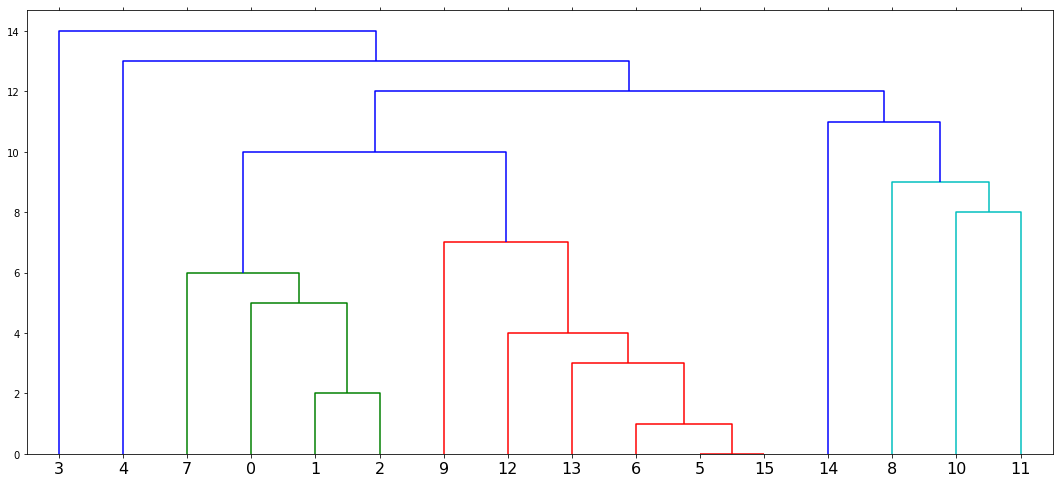

In [ ]:
class HierarchicalTopics(object): #dendrogram
    def __init__(self, corpus):
        self.model = None
        self.vocab = list(
            set(normalize(corpus.words()))
        )

    def vectorize(self, document):
        features = set(normalize(document))
        return np.array([
            token in features for token in self.vocab], np.short)

    def cluster(self, corpus):
        self.model = AgglomerativeClustering()
        self.model.fit_predict([
            self.vectorize(
                corpus.words(fileid)) for fileid in
            corpus.fileids(
                           )
        ])

        self.labels = self.model.labels_
        self.children = self.model.children_

    def plot_dendrogram(self, **kwargs): 
        distance = np.arange(self.children.shape[0]) #distances between each pair of children
        position = np.arange(self.children.shape[0])

        linkage_matrix = np.column_stack([
            self.children, distance, position]
        ).astype(float) #linkage matrix for children

        fig, ax = plt.subplots(figsize=(15, 7))  
        ax = dendrogram(linkage_matrix, **kwargs)
        plt.rcParams['font.size'] = '16'
        plt.tick_params(axis='x', bottom='off', top='off')
        plt.tight_layout()
        plt.show()


if __name__ == '__main__':
    from collections import Counter
    corpus = Congo_corpus
    labels = []
    for fileid in corpus.fileids():
        terms = []
        for term, count in Counter(list(normalize(corpus.words(fileid)))).most_common(10):
            terms.append(term)
        labels.append(terms)

    clusterer = HierarchicalTopics(corpus)
    clusterer.cluster(corpus)
    clusterer.plot_dendrogram(leaf_font_size=16)

In [ ]:
data = list(Congo_corpus.sents())
for sents in data:
    for token in sents.copy():
        token = token.lower().strip()
        if (token in sents) and (is_punct(token) or (token in STOPWORDS) or (token.isdigit() and len(token) < 4)):
          sents.remove(token)
id2word = Dictionary(data)
corpus = [id2word.doc2bow(text) for text in data] #dictionarized data for lda
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=10, 
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True) #latent dirichlet analysis

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
pyLDAvis.enable_notebook()
p=gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(p, 'lda.html')

In [ ]:
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.111386  0.178968       1        1  14.697525
2      0.099518 -0.094978       2        1  13.557450
3      0.025407  0.266599       3        1  12.016120
8     -0.315377 -0.017717       4        1  11.536814
5      0.083836 -0.099614       5        1  11.366193
7      0.159038  0.083549       6        1   9.817931
4      0.155015 -0.018721       7        1   8.326227
9      0.002925  0.000936       8        1   8.092883
1     -0.042017 -0.136748       9        1   5.983541
0     -0.056959 -0.162272      10        1   4.605318, topic_info=             Term        Freq       Total Category  logprob  loglift
221           ICC  993.000000  993.000000  Default  30.0000  30.0000
840   Prosecution  977.000000  977.000000  Default  29.0000  29.0000
1304        Trial  514.000000  514.000000  Default  28.0000  28.0000
586       Defence  476.000000  476.000000  Default  27.0000  27.0000
1535            T  334.000000  334.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
6079         2008   35.499618  399.272524  Topic10  -4.3322   0.6578
0            2003   22.768927  125.644799  Topic10  -4.7763   1.3699
6520     incident   14.285814   46.217447  Topic10  -5.2425   1.9039
6418       counts   16.158448  157.387101  Topic10  -5.1193   0.8017
6067    Timetable   11.232616   23.483163  Topic10  -5.4829   2.3405

[453 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
6347      1  0.100834  00d235
6347      2  0.033611  00d235
6347      3  0.033611  00d235
6347      4  0.672230  00d235
6347      9  0.033611  00d235
...     ...       ...     ...
247       3  0.069383     www
247       4  0.926952     www
1254     10  0.864169    xxvi
936       2  0.992537   years
3309      9  0.949629       à

[716 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 4, 9, 6, 8, 5, 10, 2, 1])